In [6]:
import numpy as np
import scipy.fft as fft

In [2]:
np.polynomial.Legendre.basis(4)

Legendre([0., 0., 0., 0., 1.], domain=[-1.,  1.], window=[-1.,  1.])

In [3]:
x = np.random.uniform(0,1,20)

In [9]:
np.fft.fft(x)

array([ 9.60922612+0.j        , -1.18419535+0.42965171j,
       -0.14244459+0.43259111j, -2.33641867-0.25685021j,
        0.29005252+0.98128949j, -0.7073733 -0.02474239j,
       -1.35874018-1.13969557j,  0.19948438-1.29782027j,
        0.4968781 +0.05073114j,  0.03031735+0.04766876j,
       -0.05910793+0.j        ,  0.03031735-0.04766876j,
        0.4968781 -0.05073114j,  0.19948438+1.29782027j,
       -1.35874018+1.13969557j, -0.7073733 +0.02474239j,
        0.29005252-0.98128949j, -2.33641867+0.25685021j,
       -0.14244459-0.43259111j, -1.18419535-0.42965171j])

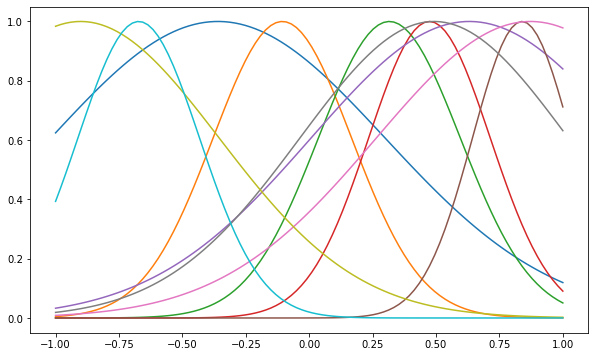

In [53]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10,6))

loc = [[-1.25, -0.4],
       [0., 1.25],
       [1.25, -0.4]]

mu = np.random.uniform(-1,1, 10)
ell = np.random.uniform(0,1, 10)

x = np.linspace(-1,1,100).reshape(-1,1)

def radial_basis(x):
    return np.exp(-(x - mu)**2/ell)

bases = radial_basis(x)
plt.plot(x, bases)


def hyperbolic_tangent(x, num_basis=4, data_limits=[-1., 1.], gain=None):
    """Hyperbolic tangents"""
    if num_basis>2:
        centres=np.linspace(data_limits[0], data_limits[1], num_basis-1)
        width = (centres[1]-centres[0])/2.
    elif num_basis==2:
        centres = np.asarray([data_limits[0]/2. + data_limits[1]/2.])
        width = (data_limits[1]-data_limits[0])/2.
    else:
        centres = []
        width = None
    if gain is None and width is not None:
        gain = np.ones(num_basis-1)/width
    Phi = np.zeros((x.shape[0], num_basis))
    # Create the bias
    Phi[:, 0] = 1.0
    for i in range(1, num_basis):
        Phi[:, i:i+1] = np.tanh(gain[i-1]*(np.asarray(x, dtype=float)-centres[i-1]))
    return Phi



# text = ['$\phi_1(x) = e^{-(x + 1)^2}$',
#         '$\phi_2(x) = e^{-2x^2}$', 
#         '$\phi_3(x) = e^{-2(x-1)^2}$']
# plot.basis(mlai.radial, x_min=-2, x_max=2, 
#            fig=f, ax=ax, loc=loc, text=text,
#            diagrams='./ml')

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader
class ToyRegression():
    def __init__(self, n_samples=50, xmin=(1.5,4.5), xmax=(2.5,6), f=lambda x: np.sin(x), noise_var=0.25, seed=1):
        np.random.seed(seed)
        x1 = np.random.uniform(xmin[0], xmax[0], size=n_samples//2)
        x2 = np.random.uniform(xmin[1], xmax[1], size=n_samples//2)
        self.f = f
        self.n_samples = 50
        self.noise_var = noise_var
        self.x = np.concatenate([x1,x2]).reshape(-1,1)
        self.y = self.x*self.f(self.x) + np.random.normal(0, self.noise_var, self.x.shape[1])
    
    def get_train_data(self):
        return (self.x, self.y)

    def plot_dataset(self):
        plt.scatter(self.x, self.y)
        return
    
class ToyRegressionDataset(Dataset):
    def __init__(self, **kwargs):
        X, y = ToyRegression(**kwargs).get_train_data()
        self.x = torch.tensor(X).type(torch.float)
        self.y = torch.tensor(y).type(torch.float)
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

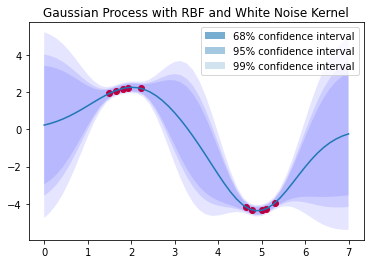

In [63]:
# This cell is used to fit a GP to compare in the evaluation section.

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel


train_ds = ToyRegressionDataset(n_samples=10)
X = train_ds.x.numpy()
y = train_ds.y.numpy().flatten()

kernel = 0.1 * RBF(length_scale=1, length_scale_bounds=(1e-5, 0.8)) + WhiteKernel(
    0.1, noise_level_bounds=(1e-2, 1)
)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)
    xtest_gp = np.linspace(0, 7, 50)
    gp_pred, sigma = gp.predict(xtest_gp.reshape(-1, 1), return_std=True)
    

plt.plot(xtest_gp, gp_pred)
plt.scatter(train_ds.x.detach(), train_ds.y.detach(), c="r")
for z, cint in [(1.645, 68), (1.96, 95), (2.575, 99)]:
    plt.fill_between(
        np.concatenate([xtest_gp, xtest_gp[::-1]]),
        np.concatenate([gp_pred - z * sigma, (gp_pred + z * sigma)[::-1]]),
        alpha=0.1,
        fc="b",
        label=f"{cint}% confidence interval",
    )
leg = plt.legend()
a = 0.8
for lh in leg.legendHandles: 
    a -= 0.2
    lh.set_alpha(a)
    

plt.title('Gaussian Process with RBF and White Noise Kernel')
plt.show()

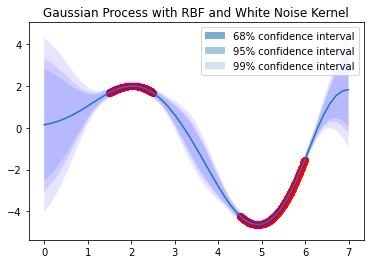

In [65]:
# This cell is used to fit a GP to compare in the evaluation section.

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel


train_ds = ToyRegressionDataset(n_samples=1000)
X = train_ds.x.numpy()
y = train_ds.y.numpy().flatten()

kernel = 0.1 * RBF(length_scale=1, length_scale_bounds=(1e-5, 0.8)) + WhiteKernel(
    0.1, noise_level_bounds=(1e-2, 1)
)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)
    xtest_gp = np.linspace(0, 7, 50)
    gp_pred, sigma = gp.predict(xtest_gp.reshape(-1, 1), return_std=True)
    

plt.plot(xtest_gp, gp_pred)
plt.scatter(train_ds.x.detach(), train_ds.y.detach(), c="r")
for z, cint in [(1.645, 68), (1.96, 95), (2.575, 99)]:
    plt.fill_between(
        np.concatenate([xtest_gp, xtest_gp[::-1]]),
        np.concatenate([gp_pred - z * sigma, (gp_pred + z * sigma)[::-1]]),
        alpha=0.1,
        fc="b",
        label=f"{cint}% confidence interval",
    )
leg = plt.legend()
a = 0.8
for lh in leg.legendHandles: 
    a -= 0.2
    lh.set_alpha(a)
    

plt.title('Gaussian Process with RBF and White Noise Kernel')
plt.show()